# 1. 前期准备

In [4]:
from datasets import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
    GenerationConfig,
)

# 2. 导入数据

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("./data/train_dataset.csv")
label = data["label"]
data = data[["joke", "pinyin", "标签"]]
data_train, data_val, label_train, label_val = train_test_split(
    data, label, test_size=0.1, random_state=648
)
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)

In [3]:
data_train = Dataset.from_pandas(data_train)
data_train[0]

{'joke': '话说一日阿南当飞行员的好朋友阿平跟他借车阿南借出之后一直心惊胆颤的小明看到就问他：你担心啥啊？你担心他出事？ 阿南答道：不！我担心我的车子！ 你知道他的职业吗？飞行员耶！ 我怕他超车的时候，不从左超，也不从右超，偏偏直线加速，然后拉起方向盘。',
 'pinyin': 'hua4 shuo1 yi1 ri4 a1 nan2 dang1 fei1 xing2 yuan2 de5 hao3 peng2 you3 a1 ping2 gen1 ta1 jie4 che1 a1 nan2 jie4 chu1 zhi1 hou4 yi1 zhi2 xin1 liang2 dan3 zhan4 de5 xiao3 ming2 kan4 dao4 jiu4 wen4 ta1 ： ni3 dan4 xin1 sha4 a5 ？ ni3 dan4 xin1 ta1 chu1 shi4 ？   a1 nan2 da2 dao4 ： bu4 ！ wo3 dan4 xin1 wo3 de5 che1 zi3 ！   ni3 zhi1 dao4 ta1 de5 zhi2 ye4 ma5 ？ fei1 xing2 yuan2 ye2 ！   wo3 pa4 ta1 chao1 che1 de5 shi2 hou4 ， bu4 cong2 zuo3 chao1 ， ye3 bu4 cong2 you4 chao1 ， pian1 pian1 zhi2 xian4 jia1 su4 ， ran2 hou4 la1 qi3 fang1 xiang4 pan2 。',
 '标签': '一般幽默'}

In [4]:
data_val = Dataset.from_pandas(data_val)
data_val[0]

{'joke': '我们班有一个女生和一个特别老实的男生开玩笑说：“你看，我的皮肤就像剥了壳的鸡蛋。” 那男生沉默半晌，特别认真的说出一句话：“是茶叶蛋吧！”',
 'pinyin': 'wo3 men5 ban1 you3 yi1 ge4 nv3 sheng1 he2 yi1 ge4 te4 bie2 lao3 shi2 de5 nan2 sheng1 kai1 wan2 xiao4 shuo1 ： “ ni3 kan4 ， wo3 de5 pi2 fu1 jiu4 xiang4 bo1 le5 ke2 de5 ji1 dan4 。 ”   na4 nan2 sheng1 chen2 mo4 ban4 shang3 ， te4 bie2 ren4 zhen1 de5 shuo1 chu1 yi1 ju4 hua4 ： “ shi4 cha2 ye4 dan4 ba5 ！ ”',
 '标签': '强幽默'}

In [5]:
data_test = pd.read_csv("./data/test_dataset.csv")
label_test = data_test["label"]
data_test = data_test[["joke", "pinyin", "标签"]]
data_test = Dataset.from_pandas(data_test)
data_test[0]

{'joke': '车上遇见一对双胞胎姑娘。穿的那个清凉啊，笑的那个甜啊……忍不住要去搭讪。 为不表现的轻浮和唐突，在心中默念了好几遍准备好的台词才走凑上去对她倆说：你们谁想做我小姨子？',
 'pinyin': 'che1 shang4 yu4 jian4 yi1 dui4 shuang1 bao1 tai1 gu1 niang2 。 chuan1 de5 na4 ge4 qing1 liang2 a5 ， xiao4 de5 na4 ge4 tian2 a5 … … ren3 bu4 zhu4 yao4 qu4 da1 shan4 。   wei4 bu4 biao3 xian4 de5 qing1 fu2 he2 tang2 tu1 ， zai4 xin1 zhong1 mo4 nian4 le5 hao3 ji1 bian4 zhun3 bei4 hao3 de5 tai2 ci2 cai2 zou3 cou4 shang4 qu4 dui4 ta1 lia3 shuo1 ： ni3 men5 shui2 xiang3 zuo4 wo3 xiao3 yi2 zi3 ？',
 '标签': '强幽默'}

# 导入分词器并处理数据

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    "../autodl-tmp/Qwen1___5-7B-Chat-GPTQ-Int4", trust_remote_code=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


接下来编写一个输入处理函数，对输入进行分词、编码和长度限制处理。

In [7]:
def process_func(data_input):
    """对输入进行分词、编码和长度限制处理，以便后续用于模型的训练或推理

    Args:
        data_input (dataframe): 需要处理的数据

    Returns:
        _type_: 以字典形式返回处理后的数据
    """
    # 设置最大长度，用于控制输入的长度
    MAX_LENGTH = 400
    # 初始化用于存储处理后数据的列表
    input_ids, attention_mask, labels = [], [], []

    # 使用分词器对指令和输出部分进行处理，将其转换为input_ids和attention_mask
    system_content = "你是一位语言学家，请根据以下文本中的幽默，将其准确分类为弱幽默、一般幽默或强幽默。输出只能是'弱幽默','一般幽默','强幽默'三者之一。"
    instruction = tokenizer(
        f"<|im_start|>system\n{system_content}<|im_end|>\n<|im_start|>user\n{data_input['joke']}<|im_end|>\n<|im_start|>assistant\n",
        add_special_tokens=False,
    )
    response = tokenizer(f"{data_input['标签']}", add_special_tokens=False)

    # 将指令部分和输出部分合并，并加入一些结尾标志
    input_ids = (
        instruction["input_ids"] + response["input_ids"] + [tokenizer.pad_token_id]
    )
    attention_mask = instruction["attention_mask"] + response["attention_mask"] + [1]
    # 对labels进行设置，指令部分用-100进行填充，其余部分使用输出部分的input_ids
    labels = (
        [-100] * len(instruction["input_ids"])
        + response["input_ids"]
        + [tokenizer.pad_token_id]
    )

    # 如果输入长度超过最大长度限制，则进行截断
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [8]:
dataset_train = data_train.map(process_func, remove_columns=data_train.column_names)
dataset_train

Map:   0%|          | 0/11268 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 11268
})

In [9]:
dataset_val = data_val.map(process_func, remove_columns=data_val.column_names)
dataset_val

Map:   0%|          | 0/1253 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1253
})

In [10]:
tokenizer.decode(dataset_train[0]["input_ids"])

"<|im_start|>system\n你是一位语言学家，请根据以下文本中的幽默，将其准确分类为弱幽默、一般幽默或强幽默。输出只能是'弱幽默','一般幽默','强幽默'三者之一。<|im_end|>\n<|im_start|>user\n话说一日阿南当飞行员的好朋友阿平跟他借车阿南借出之后一直心惊胆颤的小明看到就问他：你担心啥啊？你担心他出事？ 阿南答道：不！我担心我的车子！ 你知道他的职业吗？飞行员耶！ 我怕他超车的时候，不从左超，也不从右超，偏偏直线加速，然后拉起方向盘。<|im_end|>\n<|im_start|>assistant\n一般幽默<|endoftext|>"

# 4. 导入模型

In [11]:
import torch

model = AutoModelForCausalLM.from_pretrained(
    "../autodl-tmp/Qwen1___5-7B-Chat-GPTQ-Int4", device_map="auto"
)
model

CUDA extension not installed.
CUDA extension not installed.
/root/miniconda3/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-31): 32 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (rotary_emb): Qwen2RotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): Qwen2MLP(
          (act_fn): SiLU()
          (down_proj): QuantLinear()
          (gate_proj): QuantLinear()
          (up_proj): QuantLinear()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=151936, bias=False)
)

以下是一些模型信息

In [12]:
model.hf_quantizer.is_trainable

True

In [13]:
model.dtype

torch.float16

In [14]:
# 开启梯度检查点时，要执行该方法
model.enable_input_require_grads()

# 5. 设置LORA

In [12]:
from peft import LoraConfig, TaskType, get_peft_model

config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    inference_mode=False,  # 训练模式
    r=8,  # Lora 秩
    lora_alpha=32,  # Lora alaph
    lora_dropout=0.1,  # Dropout 比例
)
config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, r=8, target_modules={'up_proj', 'gate_proj', 'down_proj', 'v_proj', 'k_proj', 'o_proj', 'q_proj'}, lora_alpha=32, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

In [16]:
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 19,988,480 || all params: 1,264,914,432 || trainable%: 1.580223886638365


# 5. 训练模型

In [17]:
args = TrainingArguments(
    output_dir="./output/Qwen",
    logging_dir="./log/Qwen",
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    logging_steps=50,
    num_train_epochs=10,
    save_steps=200,
    learning_rate=1e-4,
    save_on_each_node=True,
    gradient_checkpointing=True,
    evaluation_strategy="steps",
)

In [18]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

/root/miniconda3/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
model = model.train()
trainer.train()

In [41]:
trainer.state.log_history[-1]

{'train_runtime': 13993.0434,
 'train_samples_per_second': 8.053,
 'train_steps_per_second': 0.126,
 'total_flos': 7.908242624810189e+16,
 'train_loss': 0.11842206811521795,
 'epoch': 9.99,
 'step': 1760}

In [43]:
log1 = pd.DataFrame(trainer.state.log_history[:-1:2])
log1.to_csv("./log/log_train.csv")
log1

,loss,grad_norm,learning_rate,epoch,step
0,0.5953,1.416130,9.715909e-05,0.28,50
1,0.2957,1.410649,9.431818e-05,0.57,100
2,0.3032,0.736870,9.147727e-05,0.85,150
3,0.2922,1.955565,8.863636e-05,1.13,200
4,0.2793,1.194099,8.579545e-05,1.42,250
5,0.2993,0.681697,8.295455e-05,1.70,300
6,0.2834,1.484904,8.011364e-05,1.99,350
7,0.2485,2.011010,7.727273e-05,2.27,400
8,0.2479,1.616669,7.443182e-05,2.55,450
9,0.2439,2.010336,7.159091e-05,2.84,500


In [44]:
log2 = pd.DataFrame(trainer.state.log_history[1::2])
log2.to_csv("./log/log_eval.csv")
log2

,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.296076,44.4818,28.169,1.776,0.28,50
1,0.319056,44.4102,28.214,1.779,0.57,100
2,0.322706,44.4011,28.220,1.779,0.85,150
3,0.300211,44.3795,28.234,1.780,1.13,200
4,0.348036,44.4144,28.212,1.779,1.42,250
5,0.285136,44.3888,28.228,1.780,1.70,300
6,0.286006,44.3468,28.255,1.781,1.99,350
7,0.330289,44.3467,28.255,1.781,2.27,400
8,0.297577,44.3388,28.260,1.782,2.55,450
9,0.305336,44.3804,28.233,1.780,2.84,500


# 6. 评估模型

## 评估分类结果

In [20]:
content_list = data_test["joke"]

In [10]:
device = "cuda"


def generate_response(system_content, content):
    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": content},
    ]
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    generated_ids = model.generate(model_inputs.input_ids, max_new_tokens=256)
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response

In [22]:
responses = []
max_retries = 5
system_content = "你是一位语言学家，请根据以下文本中的幽默，将其准确分类为弱幽默、一般幽默或强幽默。输出只能是'弱幽默','一般幽默','强幽默'三者之一。"

In [ ]:
model = model.eval()

In [23]:
from tqdm.notebook import trange

for i in trange(len(content_list)):
    retries = 0
    while retries < max_retries:
        response = generate_response(system_content, content_list[i])
        if response in ["弱幽默", "一般幽默", "强幽默"]:
            responses.append(response)
            break
        else:
            retries += 1
            print(f"回答{i}生成错误！生成的结果为：{response}")
    else:
        print(f"回答{i}生成错误次数超过上限！")

  0%|          | 0/3130 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [28]:
data_pred = pd.DataFrame(responses)
data_pred["pred_label"] = data_pred[0].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
data_pred[0].value_counts()

0
一般幽默    2252
弱幽默      521
强幽默      357
Name: count, dtype: int64

In [17]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate(targets, outputs):
    conf = metrics.confusion_matrix(targets, outputs)
    data = pd.DataFrame(
        conf,
        columns=["weak humor", "normal humor", "strong humor"],
        index=["weak humor", "normal humor", "strong humor"],
    )
    plt.figure(figsize=(6, 5))
    sns.heatmap(data, cmap=plt.cm.Blues, annot=True, fmt="d")
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()
    print("Classification Report")
    print(metrics.classification_report(targets, outputs))

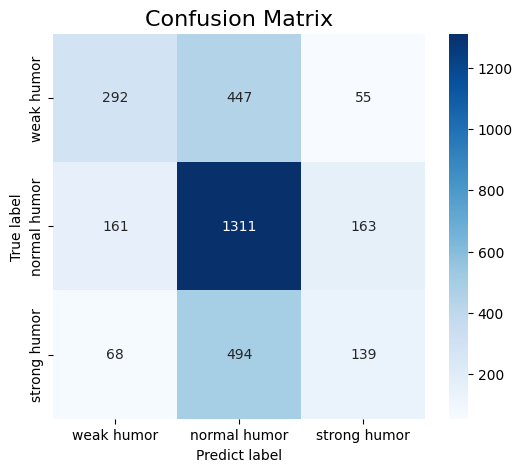

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.37      0.44       794
           1       0.58      0.80      0.67      1635
           2       0.39      0.20      0.26       701

    accuracy                           0.56      3130
   macro avg       0.51      0.46      0.46      3130
weighted avg       0.53      0.56      0.52      3130



In [32]:
evaluate(label_test, data_pred["pred_label"])

## 绘制损失函数图

In [6]:
loss_train = pd.read_csv("./log/log_train.csv")
loss_train.head()

,Unnamed: 0,loss,grad_norm,learning_rate,epoch,step
0,0,0.5953,1.416130,0.000097,0.28,50
1,1,0.2957,1.410649,0.000094,0.57,100
2,2,0.3032,0.736870,0.000091,0.85,150
3,3,0.2922,1.955565,0.000089,1.13,200
4,4,0.2793,1.194099,0.000086,1.42,250


In [7]:
loss_eval = pd.read_csv("./log/log_eval.csv")
loss_eval.head()

,Unnamed: 0,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0,0.296076,44.4818,28.169,1.776,0.28,50
1,1,0.319056,44.4102,28.214,1.779,0.57,100
2,2,0.322706,44.4011,28.220,1.779,0.85,150
3,3,0.300211,44.3795,28.234,1.780,1.13,200
4,4,0.348036,44.4144,28.212,1.779,1.42,250


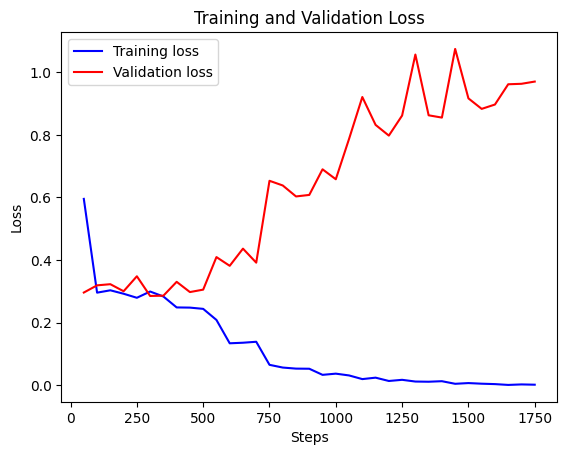

In [9]:
def plot_loss(steps, train_loss, val_loss):
    plt.plot(steps, train_loss, "b", label="Training loss")
    plt.plot(steps, val_loss, "r", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


# 例如：
steps = loss_train["step"]
train_loss = loss_train["loss"]
val_loss = loss_eval["eval_loss"]

plot_loss(steps, train_loss, val_loss)

# 8. 模型再加载与评估

## 检查点400

In [60]:
torch.cuda.empty_cache()

In [46]:
# 加载lora权重
from peft import PeftModel

mode_path = "../autodl-tmp/Qwen1___5-7B-Chat-GPTQ-Int4"
# 加载tokenizer
tokenizer = AutoTokenizer.from_pretrained(mode_path)

# 加载模型
model = AutoModelForCausalLM.from_pretrained(
    mode_path, device_map="auto", torch_dtype=torch.bfloat16
)

model = PeftModel.from_pretrained(
    model, model_id="./output/Qwen/checkpoint-400", config=config
)

model = model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/root/miniconda3/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
responses = []

In [47]:
from tqdm.notebook import trange

for i in trange(len(content_list)):
    retries = 0
    while retries < max_retries:
        response = generate_response(system_content, content_list[i])
        if response in ["弱幽默", "一般幽默", "强幽默"]:
            responses.append(response)
            break
        else:
            retries += 1
            print(f"回答{i}生成错误！生成的结果为：{response}")
    else:
        print(f"回答{i}生成错误次数超过上限！")

  0%|          | 0/3130 [00:00<?, ?it/s]

In [58]:
data_pred = pd.DataFrame(responses, columns=["预测标签"])
data_pred["label"] = label_test
data_pred["pred_label"] = data_pred["预测标签"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
data_pred["预测标签"].value_counts()

/tmp/ipykernel_6107/1521281013.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_pred["pred_label"] = data_pred["预测标签"].replace(


预测标签
强幽默     1336
一般幽默    1297
弱幽默      497
Name: count, dtype: int64

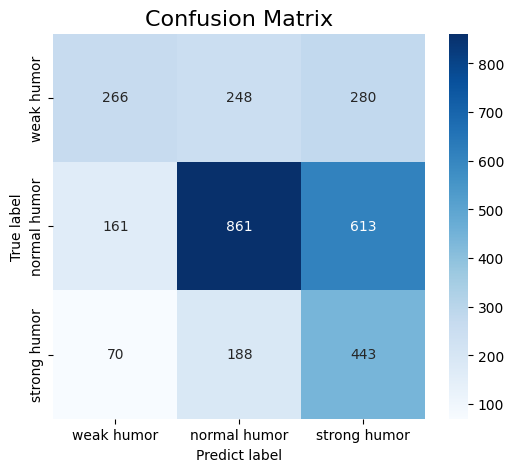

Classification Report
              precision    recall  f1-score   support

           0       0.54      0.34      0.41       794
           1       0.66      0.53      0.59      1635
           2       0.33      0.63      0.43       701

    accuracy                           0.50      3130
   macro avg       0.51      0.50      0.48      3130
weighted avg       0.56      0.50      0.51      3130



In [59]:
evaluate(data_pred["label"], data_pred["pred_label"])

In [61]:
data_pred.to_csv("./data/test_prediction_qwen_finetune_400.csv")

## 检查点1000

In [13]:
# 加载lora权重
from peft import PeftModel
import torch

mode_path = "../autodl-tmp/Qwen1___5-7B-Chat-GPTQ-Int4"
# 加载tokenizer
tokenizer = AutoTokenizer.from_pretrained(mode_path)

# 加载模型
model = AutoModelForCausalLM.from_pretrained(
    mode_path, device_map="auto", torch_dtype=torch.bfloat16
)

model = PeftModel.from_pretrained(
    model, model_id="./output/Qwen/checkpoint-1000", config=config
)

model = model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
content_list = data_test["joke"]
responses = []
max_retries = 5
system_content = "你是一位语言学家，请根据以下文本中的幽默，将其准确分类为弱幽默、一般幽默或强幽默。输出只能是'弱幽默','一般幽默','强幽默'三者之一。"

In [15]:
from tqdm.notebook import trange

for i in trange(len(content_list)):
    retries = 0
    while retries < max_retries:
        response = generate_response(system_content, content_list[i])
        if response in ["弱幽默", "一般幽默", "强幽默"]:
            responses.append(response)
            break
        else:
            retries += 1
            print(f"回答{i}生成错误！生成的结果为：{response}")
    else:
        print(f"回答{i}生成错误次数超过上限！")

  0%|          | 0/3130 [00:00<?, ?it/s]

In [19]:
data_pred = pd.DataFrame(responses, columns=["预测标签"])
data_pred["label"] = label_test
data_pred["pred_label"] = data_pred["预测标签"].replace(
    {"弱幽默": 0, "一般幽默": 1, "强幽默": 2}
)
data_pred["预测标签"].value_counts()

/tmp/ipykernel_10347/1521281013.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_pred["pred_label"] = data_pred["预测标签"].replace(


预测标签
一般幽默    2079
弱幽默      562
强幽默      489
Name: count, dtype: int64

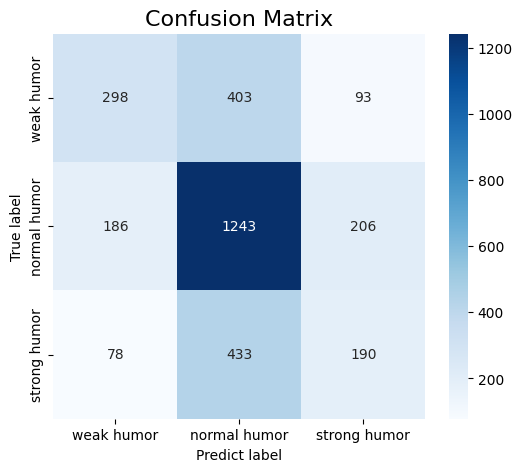

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.38      0.44       794
           1       0.60      0.76      0.67      1635
           2       0.39      0.27      0.32       701

    accuracy                           0.55      3130
   macro avg       0.51      0.47      0.48      3130
weighted avg       0.53      0.55      0.53      3130



In [18]:
evaluate(data_pred["label"], data_pred["pred_label"])

In [ ]:
data_pred.to_csv("./data/test_prediction_qwen_finetune_1000.csv")